In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 12 15:35:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
 
from tqdm import tqdm
import re
import string
from itertools import combinations
from collections import Counter
 
 
from flair.models import SequenceTagger
from flair.data import Sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import re

# filename = "Harry Potter - 0-MischiefManaged-0 - Stupid Bloody Gingers.txt"

def read_file(filename):

  file1 = open(filename, 'r')
  lines = file1.readlines()
  story = []
  i = 0

  for line in lines:
    # print(line)
    if 'Language:' in line and 'English' not in line:
      print("returning because language")
      return story
    if 'Chapter' in line:
      print("found chapter")
      story = lines[i:]
      break
    i+=1
  print(story)

  i = 0 
  for line in story:
    # line = ' '.join(e for e in line if e.isalnum())
    # print(line)
    line = line.replace('<br>', '')
    line = line.replace('>', '')
    story[i] = re.sub('[^A-Za-z0-9]+', ' ', line)
    i+=1
  
  return story


# print(story)

In [6]:
def read_original_file(filename):

  file1 = open(filename, 'r')
  lines = file1.readlines()
  story = []

  for line in lines:
    if 'Page |' in line:
      # print("page: ", line)
      continue
    story.append(line)

  i = 0 
  for line in story:
    # line = ' '.join(e for e in line if e.isalnum())
    # print(line)
    line = line.replace('<br>', '')
    line = line.replace('>', '')
    story[i] = re.sub('[^A-Za-z0-9]+', ' ', line)
    i+=1
  
  return story

In [7]:
def get_people(story):

  # Use flair named entity recognition
  tagger = SequenceTagger.load('ner')

  # Get all the names of entities tagged as people
  
  x = []
  
  for line in tqdm(story):
    sentence = Sentence(line)
    tagger.predict(sentence)
    # print(sentence)
    # break
    # try:
    for entity in sentence.get_spans('ner'):
      # print(entity.tag)
      # print(entity.text)
      if entity.tag == 'PER':
        x.append(entity.text)
      # if 'PER' == entity['labels'][0].value:
      #   x.append(entity['text'])
      # break
    # except KeyError:
    #   # print("KeyError sentence: ", sentence)
    #   continue

  # Remove any punctuation within the names
  names = []
  for name in x:
    names.append(name.translate(str.maketrans('', '', string.punctuation)))
  
  return names

In [ ]:
# Main function
from os import listdir
from os.path import isfile, join

path = "/content/drive/MyDrive/Taneea Project/Twilight Data files"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
all_people = []
i=0

for filename in onlyfiles[:200]:
  print("Processing file: ", filename, " i: ", i)
  clean_story = read_file(path + '/' + filename)
  if len(clean_story) == 0:
    print("Empty story!\n")
    continue
  # print(clean_story)
  # break
  print("Getting people for file: ", filename)
  people = get_people(clean_story[4:])
  all_people.append(people)
  i = i + 1

print(all_people)

In [ ]:
def flatten(seq):
    l = []
    for elt in seq:
        t = type(elt)
        if t is tuple or t is list:
            for elt2 in flatten(elt):
                l.append(elt2)
        else:
            l.append(elt)
    return l

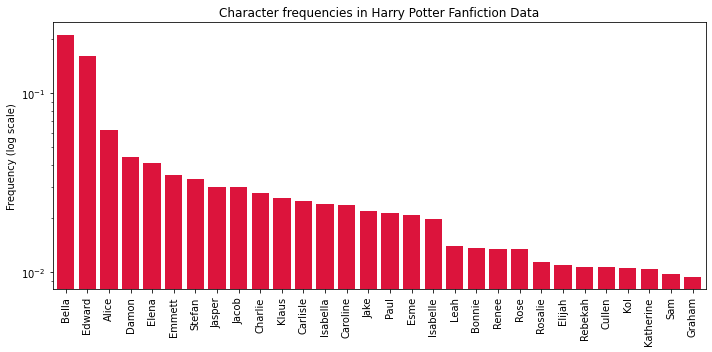

In [ ]:
# List characters by the frequency with which they are mentioned
# result = [item for items, c in Counter(x).most_common()
#                                      for item in [items] * c]
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

all_people = flatten(all_people)
ap_counter = Counter(all_people)
# print(Counter(all_people).most_common())
y = [count for tag, count in ap_counter.most_common(30)]
total = sum(y)
y = [v/total for v in y]
# total = sum(ap_counter.values())
# result = {k: v / total for k,v in ap_counter.items()}
# print(result)
# print(y)
x = [tag for tag, count in ap_counter.most_common(30)]

plt.figure(figsize=(10, 5))
plt.bar(x, y, color='crimson')
plt.title("Character frequencies in Harry Potter Fanfiction Data")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
# for i, (tag, count) in enumerate(ap_counter.most_common(30)):
#     plt.text(i, count, f' {count} ', rotation=90,
#              ha='center', va='top' if i < 15 else 'bottom', color='white' if i < 15 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

In [ ]:
# Main function for Originals
from os import listdir
from os.path import isfile, join

path = "/content/drive/MyDrive/Taneea Project/Original Books/Twilight"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
all_people_orig = []

for filename in onlyfiles:
  print("Processing file: ", filename)
  clean_story = read_original_file(path + '/' + filename)
  if len(clean_story) == 0:
    print("Empty story\n")
    continue
  # print(clean_story)
  # break
  print("Getting people for file: ", filename)
  people = get_people(clean_story)
  all_people_orig.append(people)
  # break

print(all_people_orig)

In [ ]:
all_people_orig

[['Noble',
  'Charlie',
  'Bella',
  'Phil',
  'Charlie',
  'Don',
  'Charlie',
  'Charlie',
  'Charlie Neither',
  'Charlie',
  'Charlie',
  'Swan',
  'Charlie',
  'Bells',
  'Charlie',
  'Washington',
  'Billy Black',
  'Charlie',
  'Charlie',
  'Billy',
  'Bella',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Charlie',
  'Billy',
  'Charlie',
  'Isabella Swan I',
  'Charlie',
  'Mason',
  'Chaucer Faulkner I',
  'Isabella Swan',
  'Bella',
  'Jefferson',
  'Eric',
  'Eric',
  'Varner',
  'Eric',
  'Edward',
  'Emmett Cullen',
  'Rosalie',
  'Jasper Hale',
  'Alice Cullen',
  'Cullen',
  'Jessica',
  'Jessica',
  'Jessica',
  'Emmett',
  'Rosalie',
  'Jasper',
  'Alice',
  'Cullens',
  'Cullen',
  'Jasper',
  'Rosalie',
  'Cullen',
  'Jessica',
  'Cullen',
  'Pity',
  'Cullens',
  'Edward He',
  'Edward',
  'Jessica',
  'Angela',
  'Angela',
  'Edward Cullen',
  'Banner',
  'Jessica',


In [ ]:
# List characters by the frequency with which they are mentioned
# result = [item for items, c in Counter(x).most_common()
#                                      for item in [items] * c]
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

all_people_orig = flatten(all_people_orig)
ap_counter = Counter(all_people_orig)
# print(Counter(all_people).most_common())
y = [count for tag, count in ap_counter.most_common(30)]
total = sum(y)
y = [v/total for v in y]
# total = sum(ap_counter.values())
# result = {k: v / total for k,v in ap_counter.items()}
# print(result)
# print(y)
x = [tag for tag, count in ap_counter.most_common(30)]

plt.figure(figsize=(10, 5))
plt.bar(x, y, color='crimson')
plt.title("Character frequencies in Harry Potter Fanfiction Data")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
# for i, (tag, count) in enumerate(ap_counter.most_common(30)):
#     plt.text(i, count, f' {count} ', rotation=90,
#              ha='center', va='top' if i < 15 else 'bottom', color='white' if i < 15 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

In [16]:
from scipy import stats
from scipy.stats.stats import pearsonr   

all_people = flatten(all_people)
ap_counter = Counter(all_people)
x_fanfic = [tag for tag, count in ap_counter.most_common(30)]
y_fanfic = [count for tag, count in ap_counter.most_common(30)]
total = sum(y_fanfic)
y_fanfic = [v/total for v in y_fanfic] 


all_people_orig = flatten(all_people_orig)
ap_counter_orig = Counter(all_people_orig)
y_orig = [count for tag, count in ap_counter_orig.most_common(30)]
total = sum(y_orig)
y_orig = [v/total for v in y_orig]
x_orig = [tag for tag, count in ap_counter_orig.most_common(30)]

dict_fanfic = {}
dict_orig = {}
for i in range(0, 30):
  dict_fanfic[x_fanfic[i]] = y_fanfic[i]
  dict_orig[x_orig[i]] = y_orig[i]

fanfic = []
orig = []
for k, v in dict_orig.items():
  try:
    fanfic.append(dict_fanfic[k])
    orig.append(v)
  except KeyError:
    fanfic.append(1.0)
    orig.append(v)

print(stats.ttest_ind(orig, fanfic))
print(pearsonr(orig, fanfic))

Ttest_indResult(statistic=-5.048324937118269, pvalue=4.71528456711153e-06)
(-0.27806990926414715, 0.13678822113441025)


In [ ]:
def get_num_chap(filename):
  file1 = open(filename, 'r')
  lines = file1.readlines()

  for line in lines:
    if "Language: " in line and "English" not in line:
      return False, 0
    if "Chapters: " in line:
      num = line.split(':')
      num_chap = int(num[1])
      break
  
  if num_chap > 2:
    return True, num_chap

  else:
    return False, num_chap


In [ ]:
from os import listdir
from os.path import isfile, join

path = "/content/drive/MyDrive/Taneea Project/Twilight Data files/"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
yf = []

for filename in onlyfiles:
  print(filename)
  valid, num = get_num_chap(path + '/' + filename)
  if valid:
    yf.append((filename, num))

yf

Twilight - FireworksandGlitter - Hope.txt
Twilight - FelineSoul1994 - Scales and Tails.txt
Twilight_ Winx Club - Imogen Mulgrew Swan 20 - Winx club season 1.txt
Twilight - FelineSoul1994 - Rosalie's Doll.txt
Twilight - FireworksandGlitter - Friends or Rivals.txt
Twilight - alouqua77 - Bella Volturi.txt
Twilight - alice-cullen-cool - un litro de l_grimas.txt
Twilight - FireworksandGlitter - Where's my red jacket_.txt
Twilight - Fictional-Creature-duh - Beautiful Soul.txt
Twilight_ Vampire Diaries - Secret forever - without you.txt
Twilight_ Vampire Diaries - VampireAngel99 - Izabela Salvatore.txt
Twilight - All The Little Flowers - We'll Wait Forever.txt
Twilight - AliceSweetCandy - Everybody's Changing.txt
Twilight_ X-Men_ The Movie - esmaganga - RE-DO_ Eclipse.txt
Twilight - alice-cullen-cool - en busca del amor.txt
Twilight_ Wolfblood - Divergentfan10163 - Cullens move AGAIN.txt
Twilight - Ficcin - A Good Day Until It Wasn't.txt
Twilight - feebes86 - Already Calling you Mine.txt
Twil

[('Twilight - FelineSoul1994 - Scales and Tails.txt', 4),
 ('Twilight_ Winx Club - Imogen Mulgrew Swan 20 - Winx club season 1.txt', 11),
 ('Twilight_ Vampire Diaries - VampireAngel99 - Izabela Salvatore.txt', 3),
 ('Twilight_ Wolfblood - Divergentfan10163 - Cullens move AGAIN.txt', 3),
 ("Twilight - Ficcin - A Good Day Until It Wasn't.txt", 6),
 ('Twilight - feebes86 - Already Calling you Mine.txt', 3),
 ('Twilight - fiftyshadesofcastle - my story_ my life.txt', 10),
 ('Twilight_ Vampire Knight - polly101 - The Revenge.txt', 3),
 ("Twilight - All That's Left is a Girl - Black Moon Rising.txt", 11),
 ('Twilight - Alice-Cullens-Twin - Fame.txt', 5),
 ('Twilight_ Vampire Diaries - Theydontknowaboutme - Isabella Marie Salvatore.txt',
  7),
 ('Twilight - Ficcin - The Bridesmaids.txt', 3),
 ('Twilight - Fenrir Vanagandr - The Wolves of Paris.txt', 4),
 ('Twilight_ Vampire Diaries - Twilight-gotaluvthemall - Blue Eyes.txt', 29),
 ('Twilight_ Vampire Diaries - TurningFateForYou - Safe In Your

In [ ]:
len(yf)

110